# **Covid-19 Detection**

In [1]:
#Import libraries

import numpy as np
import pandas as pd
import pathlib
from google.colab import drive
drive.mount('/content/drive')
import PIL
from imageio import imread
from skimage.transform import resize

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D,Conv2D, MaxPooling2D, LSTM, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers


import os
import datetime
import time
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


# Goal is to build a CNN based model without Transfer Learning which can accurately detect COVID 19.

> Performance Metrics to be optimized : Accuracy 

In this notebook, tried to cover few concept in deep learning like:
* Dropout and Batch Normalization usage
* Callback implementation
* EarlyStopping and ReduceLROnPlateau - Approach to prevent overfitting
* Impact of batch size, epoch size on Model Training.


In [11]:
data_dir_covid = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/Covid19Dataset/COVID')
data_dir_non_covid = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/Covid19Dataset/non-COVID')

# 1. Data Understanding



In [12]:
# Check how many dataset available for training for classes required
img_count_covid = len(list(data_dir_covid.glob('*.png'))) 
img_count_non_covid = len(list(data_dir_non_covid.glob('*.png'))) 

print("Image count in Covid set: ",img_count_covid)
print("Image count in Non Covid set: ",img_count_non_covid)

Image count in Covid set:  1252
Image count in Non Covid set:  1229


****Both Class have almost equal number of images, so there is no class imbalance issue in Dataset.****

## 1.1. Organize Dataset into Train, Test and validation set

folder splitting according to training, validation, test split

In [4]:
pip install split-folders

In [13]:
#Using Split-folders to split source folder in 3 categories i.e. Train (70%), Validation(20%) and Test(10%) set.
#Resource: https://pypi.org/project/split-folders/

import splitfolders
splitfolders.ratio("/content/drive/MyDrive/Colab Notebooks/Covid19Dataset", output="/content/drive/MyDrive/Colab Notebooks/dataset_covid_split",
    seed=1337, ratio=(.7, .2, .1), group_prefix=None, move=False)

Copying files: 2481 files [01:05, 37.95 files/s]


In [14]:
# Define the path for train, validation and test set

data_dir_train = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/dataset_covid_split/train')
data_dir_val = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/dataset_covid_split/val')
data_dir_test = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/dataset_covid_split/test')

In [15]:
#check total image count

#as it's already known that all images are of type.png.
img_count_train = len(list(data_dir_train.glob('*/*.png'))) 
img_count_val = len(list(data_dir_val.glob('*/*.png'))) 
img_count_test = len(list(data_dir_test.glob('*/*.png'))) 

print("Image count in Train set: ",img_count_train)
print("Image count in Val set: ",img_count_val)
print("Image count in Test set: ",img_count_test)



Image count in Train set:  1824
Image count in Val set:  559
Image count in Test set:  287


# 2. Explore the Dataset

Let's check some COVID images.

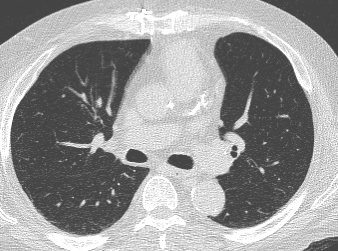

In [16]:
covid = list(data_dir_train.glob('COVID/*'))
PIL.Image.open(str(covid[0]))

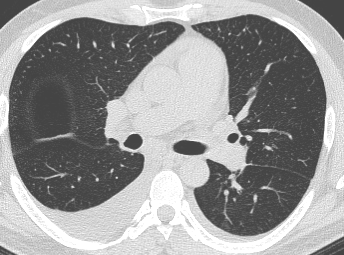

In [17]:
PIL.Image.open(str(covid[2]))

Now, Let's checkout few Non COVID images

Image size:  (463, 356)


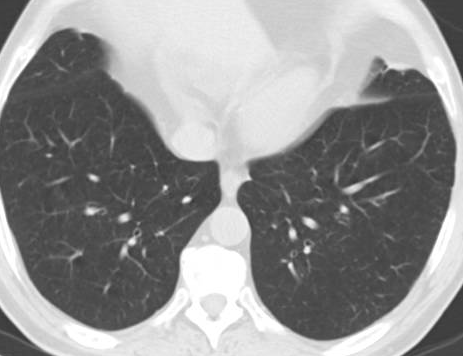

In [18]:
non_covid = list(data_dir_train.glob('non-COVID/*'))
img1 = PIL.Image.open(str(non_covid[0]))
print("Image size: " ,img1.size)
img1

Image size:  (449, 323)


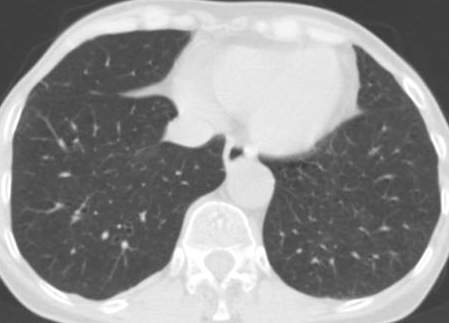

In [19]:
img2 = PIL.Image.open(str(non_covid[-1]))
print("Image size: " ,img2.size)
img2

# 3. Data Generator

Let's now use the data generator provided by Keras API.

As dataset is already splited in 3 subsets i.e. Train, Test and Validation, I will not be using validation split mechanism provided in below API.

In [20]:
def data_generator(data_source,img_height, img_width, btc_size):    
    return tf.keras.utils.image_dataset_from_directory(
        data_source,
        validation_split=None,
        subset=None,
        seed=123,
        color_mode='grayscale',
        image_size=(img_height, img_width),
        batch_size=btc_size,
        crop_to_aspect_ratio=True,
        shuffle=True
    )

***Let's define initial value of batch size, image size and num of epochs***

These are hyper parameter as well, which would help in tuning model later.

In [21]:
batch_size=32
img_height = 256
img_width = 256
num_epochs = 1

**Create dataset:**

In [22]:
train_ds = data_generator(data_dir_train,img_height, img_width, batch_size)
val_ds = data_generator(data_dir_val,img_height, img_width, batch_size)

Found 1824 files belonging to 2 classes.
Found 559 files belonging to 2 classes.


In [23]:
class_names = train_ds.class_names
print(class_names)

['COVID', 'non-COVID']


In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [25]:
normalization_layer = layers.Rescaling(1./255)

# 4. Define Common Helper Functions

In [26]:
def print_param():
    print("*** Params used in Model Training ****")
    print("Batch Size: ", batch_size)
    print("Epoch Size: ", num_epochs)
    print("Image size: {} {}".format(img_height, img_width))
    print("***********************")
    

In [27]:
""" 
Below function does following things:
    - Create training and validation dataset
    - Define callback for aving model checkpoints, early stopping, ReduceLROnPlateau
    - Fit model with defined parameters i.e. batch_size, image size, num of epochs,etc.
    - Returns History object
    
Parameters:
-----------
model_init: str
            A string to be prefixed in model checkpoint name.

"""


def train_model(model_init, model):
    
    #Create training and validation sets
    train_ds = data_generator(data_dir_train,img_height, img_width, batch_size)
    val_ds = data_generator(data_dir_val,img_height, img_width, batch_size)
    
    #File name for model checkpoint
    curr_dt_time = datetime.datetime.now()
    model_name = model_init + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    
    #Stop Training, if no improvement observed. (https://keras.io/api/callbacks/early_stopping/)
    Earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=7,verbose=1)
    
    #Reduce learning rate when perf metric stopped improving. (https://keras.io/api/callbacks/reduce_lr_on_plateau/)
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001)
    
    callbacks_list = [checkpoint, LR, Earlystop]        
    
    #Print parameters used for model training.
    print_param()
    
    
    start = time.time()
    history = model.fit(train_ds, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_ds, 
                    class_weight=None, workers=1, initial_epoch=0)
    end = time.time()
    print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")
    return history

In [28]:
def plot_metrics(history):       
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# 5. Model Building

## 5.1. Base Model to start Experiment

In [29]:
num_classes = len(class_names)

In [30]:
base_model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [31]:
base_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

In [32]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

In [33]:
#setting hyperparameters to experiment

batch_size=32
img_height = 256
img_width = 256
num_epochs = 50

In [34]:
history_base_model = train_model("base_model",base_model)

Found 1824 files belonging to 2 classes.
Found 559 files belonging to 2 classes.
*** Params used in Model Training ****
Batch Size:  32
Epoch Size:  50
Image size: 256 256
***********************
Epoch 1/50
57/57 [==============================] - ETA: 0s - loss: 0.7427 - accuracy: 0.5746
Epoch 1: val_loss improved from inf to 0.66782, saving model to base_model_2022-04-1704_29_49.268520/model-00001-0.74268-0.57456-0.66782-0.49732.h5
57/57 [==============================] - 127s 2s/step - loss: 0.7427 - accuracy: 0.5746 - val_loss: 0.6678 - val_accuracy: 0.4973 - lr: 0.0010
Epoch 2/50
57/57 [==============================] - ETA: 0s - loss: 0.5042 - accuracy: 0.7604
Epoch 2: val_loss improved from 0.66782 to 0.42680, saving model to base_model_2022-04-1704_29_49.268520/model-00002-0.50422-0.76042-0.42680-0.80501.h5
57/57 [==============================] - 118s 2s/step - loss: 0.5042 - accuracy: 0.7604 - val_loss: 0.4268 - val_accuracy: 0.8050 - lr: 0.0010
Epoch 3/50
57/57 [============

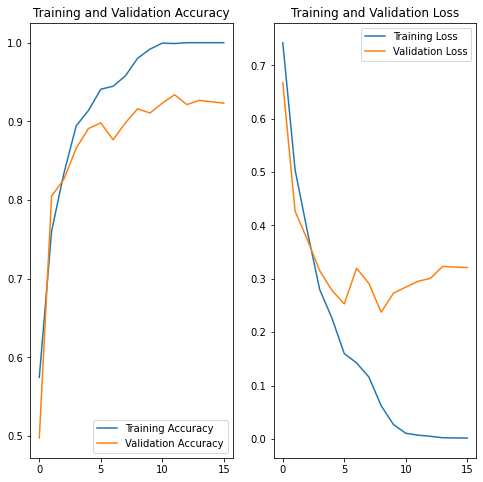

In [35]:
num_epochs = len(history_base_model.history['loss'])
plot_metrics(history_base_model)

In [36]:
min_loss_index = history_base_model.history['val_loss'].index(min(history_base_model.history['val_loss']))
print("Training Accuracy: ",history_base_model.history['accuracy'][min_loss_index])
print("Validation Accuracy: ",history_base_model.history['val_accuracy'][min_loss_index])

Training Accuracy:  0.9802631735801697
Validation Accuracy:  0.9159212708473206


**Model gives a good result with 98% Training aaccuracy and 91% validation accuracy. Let's improve this more.**

## 5.2. Let's introduce dropout and see the performance.

In [37]:
batch_size=32
img_height = 256
img_width = 256
num_epochs = 50

In [38]:
dropout_model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

dropout_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

dropout_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 1)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)       

In [39]:
history_dropout_model = train_model("dropout_model",dropout_model)

Found 1824 files belonging to 2 classes.
Found 559 files belonging to 2 classes.
*** Params used in Model Training ****
Batch Size:  32
Epoch Size:  50
Image size: 256 256
***********************
Epoch 1/50
57/57 [==============================] - ETA: 0s - loss: 0.8157 - accuracy: 0.5356
Epoch 1: val_loss improved from inf to 0.65565, saving model to dropout_model_2022-04-1705_26_40.057596/model-00001-0.81570-0.53564-0.65565-0.69589.h5
57/57 [==============================] - 119s 2s/step - loss: 0.8157 - accuracy: 0.5356 - val_loss: 0.6557 - val_accuracy: 0.6959 - lr: 0.0010
Epoch 2/50
57/57 [==============================] - ETA: 0s - loss: 0.5563 - accuracy: 0.7253
Epoch 2: val_loss improved from 0.65565 to 0.45489, saving model to dropout_model_2022-04-1705_26_40.057596/model-00002-0.55628-0.72533-0.45489-0.79070.h5
57/57 [==============================] - 117s 2s/step - loss: 0.5563 - accuracy: 0.7253 - val_loss: 0.4549 - val_accuracy: 0.7907 - lr: 0.0010
Epoch 3/50
57/57 [======

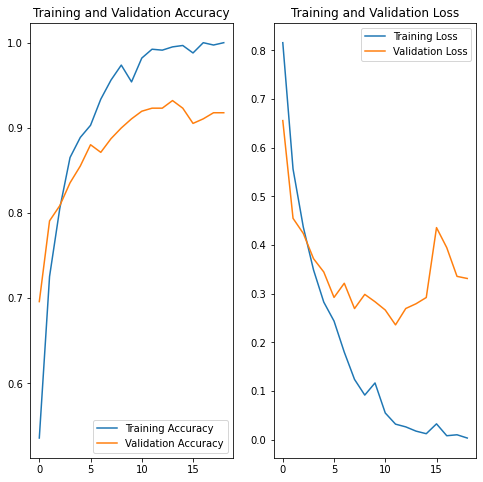

In [40]:
num_epochs = len(history_dropout_model.history['loss'])
plot_metrics(history_dropout_model)

In [41]:
min_loss_index = history_dropout_model.history['val_loss'].index(min(history_dropout_model.history['val_loss']))
print("Training Accuracy: ",history_dropout_model.history['accuracy'][min_loss_index])
print("Validation Accuracy: ",history_dropout_model.history['val_accuracy'][min_loss_index])

Training Accuracy:  0.9923245906829834
Validation Accuracy:  0.9230769276618958


**Dropout introdction seems to improve the model performance with Training accuracy 98.5% and Validation accuracy 92.5 %**

## 5.3. Batch Normalization

In [42]:
batch_size=32
img_height = 256
img_width = 256
num_epochs = 50

In [43]:
batch_norm_model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

batch_norm_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

batch_norm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 256, 256, 1)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 16)      160       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)    

In [44]:
history_batch_norm_model = train_model("batch_norm_model",batch_norm_model)

Found 1824 files belonging to 2 classes.
Found 559 files belonging to 2 classes.
*** Params used in Model Training ****
Batch Size:  32
Epoch Size:  50
Image size: 256 256
***********************
Epoch 1/50
57/57 [==============================] - ETA: 0s - loss: 2.4352 - accuracy: 0.7259
Epoch 1: val_loss improved from inf to 37.55463, saving model to batch_norm_model_2022-04-1706_12_12.841462/model-00001-2.43523-0.72588-37.55463-0.55277.h5
57/57 [==============================] - 164s 3s/step - loss: 2.4352 - accuracy: 0.7259 - val_loss: 37.5546 - val_accuracy: 0.5528 - lr: 0.0010
Epoch 2/50
57/57 [==============================] - ETA: 0s - loss: 0.2678 - accuracy: 0.8953
Epoch 2: val_loss did not improve from 37.55463
57/57 [==============================] - 166s 3s/step - loss: 0.2678 - accuracy: 0.8953 - val_loss: 71.2506 - val_accuracy: 0.5528 - lr: 0.0010
Epoch 3/50
57/57 [==============================] - ETA: 0s - loss: 0.1881 - accuracy: 0.9265
Epoch 3: val_loss did not impr

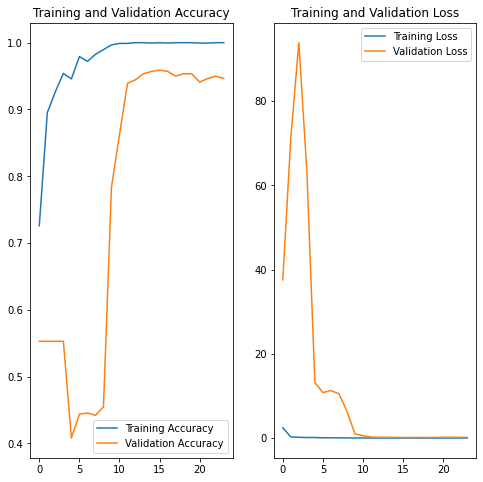

In [45]:
num_epochs = len(history_batch_norm_model.history['loss'])
plot_metrics(history_batch_norm_model)

In [46]:
min_loss_index = history_batch_norm_model.history['val_loss'].index(min(history_batch_norm_model.history['val_loss']))
print("Training Accuracy: ",history_batch_norm_model.history['accuracy'][min_loss_index])
print("Validation Accuracy: ",history_batch_norm_model.history['val_accuracy'][min_loss_index])

Training Accuracy:  0.999451756477356
Validation Accuracy:  0.9570661783218384


***Batch Normalization + Dropout outperform than previous models with Training accuracy 99.9% and Validation accuracy 95.7%***

## 5.4. Let's experiment with a larger batch size.



In [47]:
batch_size=64
img_height = 256
img_width = 256
num_epochs = 50

In [48]:
history_large_batch_model = train_model("large_batch_model",batch_norm_model)

Found 1824 files belonging to 2 classes.
Found 559 files belonging to 2 classes.
*** Params used in Model Training ****
Batch Size:  64
Epoch Size:  50
Image size: 256 256
***********************
Epoch 1/50
29/29 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 1.0000
Epoch 1: val_loss improved from inf to 0.16875, saving model to large_batch_model_2022-04-1707_29_16.417869/model-00001-0.00457-1.00000-0.16875-0.94991.h5
29/29 [==============================] - 160s 5s/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.1688 - val_accuracy: 0.9499 - lr: 1.0000e-05
Epoch 2/50
29/29 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 1.0000
Epoch 2: val_loss improved from 0.16875 to 0.16814, saving model to large_batch_model_2022-04-1707_29_16.417869/model-00002-0.00467-1.00000-0.16814-0.94991.h5
29/29 [==============================] - 155s 5s/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.1681 - val_accuracy: 0.9499 - lr: 1.0000e-05
Epoch 3/

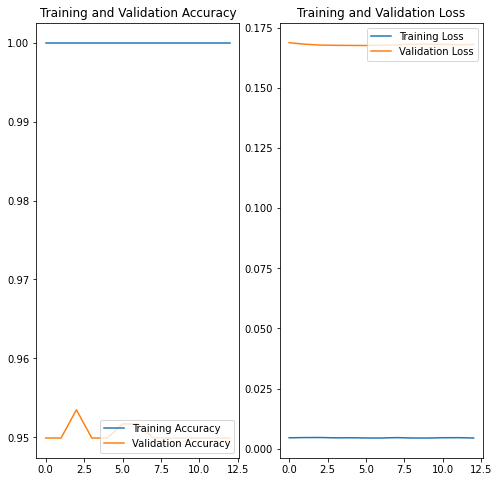

In [49]:
num_epochs = len(history_large_batch_model.history['loss'])
plot_metrics(history_large_batch_model)

In [50]:
min_loss_index = history_large_batch_model.history['val_loss'].index(min(history_large_batch_model.history['val_loss']))
print("Training Accuracy: ",history_large_batch_model.history['accuracy'][min_loss_index])
print("Validation Accuracy: ",history_large_batch_model.history['val_accuracy'][min_loss_index])

Training Accuracy:  1.0
Validation Accuracy:  0.951699435710907


**Larger Batch size seems to show almost same accuracy but training tooks lesser time.**

**Training accuracy 100% and Validation Accuracy 95.2%**

In [51]:
test_ds = data_generator(data_dir_test,img_height, img_width, batch_size)

Found 287 files belonging to 2 classes.


In [52]:
test_loss, test_acc = batch_norm_model.evaluate(test_ds, batch_size=batch_size, verbose=2)

5/5 - 9s - loss: 0.2741 - accuracy: 0.9408 - 9s/epoch - 2s/step


**Last model is used for evaluation on test dataset and it shows accuracy of 94%, which an be considered as good.**